In [1]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [2]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = [
    "lasso1_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
    "dynotears_rollingcluster_k5",
    "dynotears_nocluster",
    "var-lingam_rollingcluster_k5",
]
metric_names = ["mse", "mae", "mse_crisis", "mae_crisis"] # ["stability", "mse", "mae", "mse_crisis", "mae_crisis"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [3]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_covid_df = predictions_df.loc["2020-01-01":"2021-01-01"]
        predictions_gfc_df = predictions_df.loc["2007-06-01":"2008-06-01"]
        crisis_predictions = [predictions_covid_df, predictions_gfc_df]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"] * 100
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["diff", "rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"]) * 100
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"]) * 100

        crisis_mse = []
        crisis_mae = []
        for tmp_pred in crisis_predictions:
            tmp_mse = mean_squared_error(tmp_pred["true"], tmp_pred["prediction"])
            tmp_mae = mean_absolute_error(tmp_pred["true"], tmp_pred["prediction"])

            crisis_mse.append(tmp_mse)
            crisis_mae.append(tmp_mae)
        crisis_mse = np.mean(crisis_mse) * 100
        crisis_mae = np.mean(crisis_mae) * 100

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_crisis": [crisis_mse], 
            "mae_crisis": [crisis_mae],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

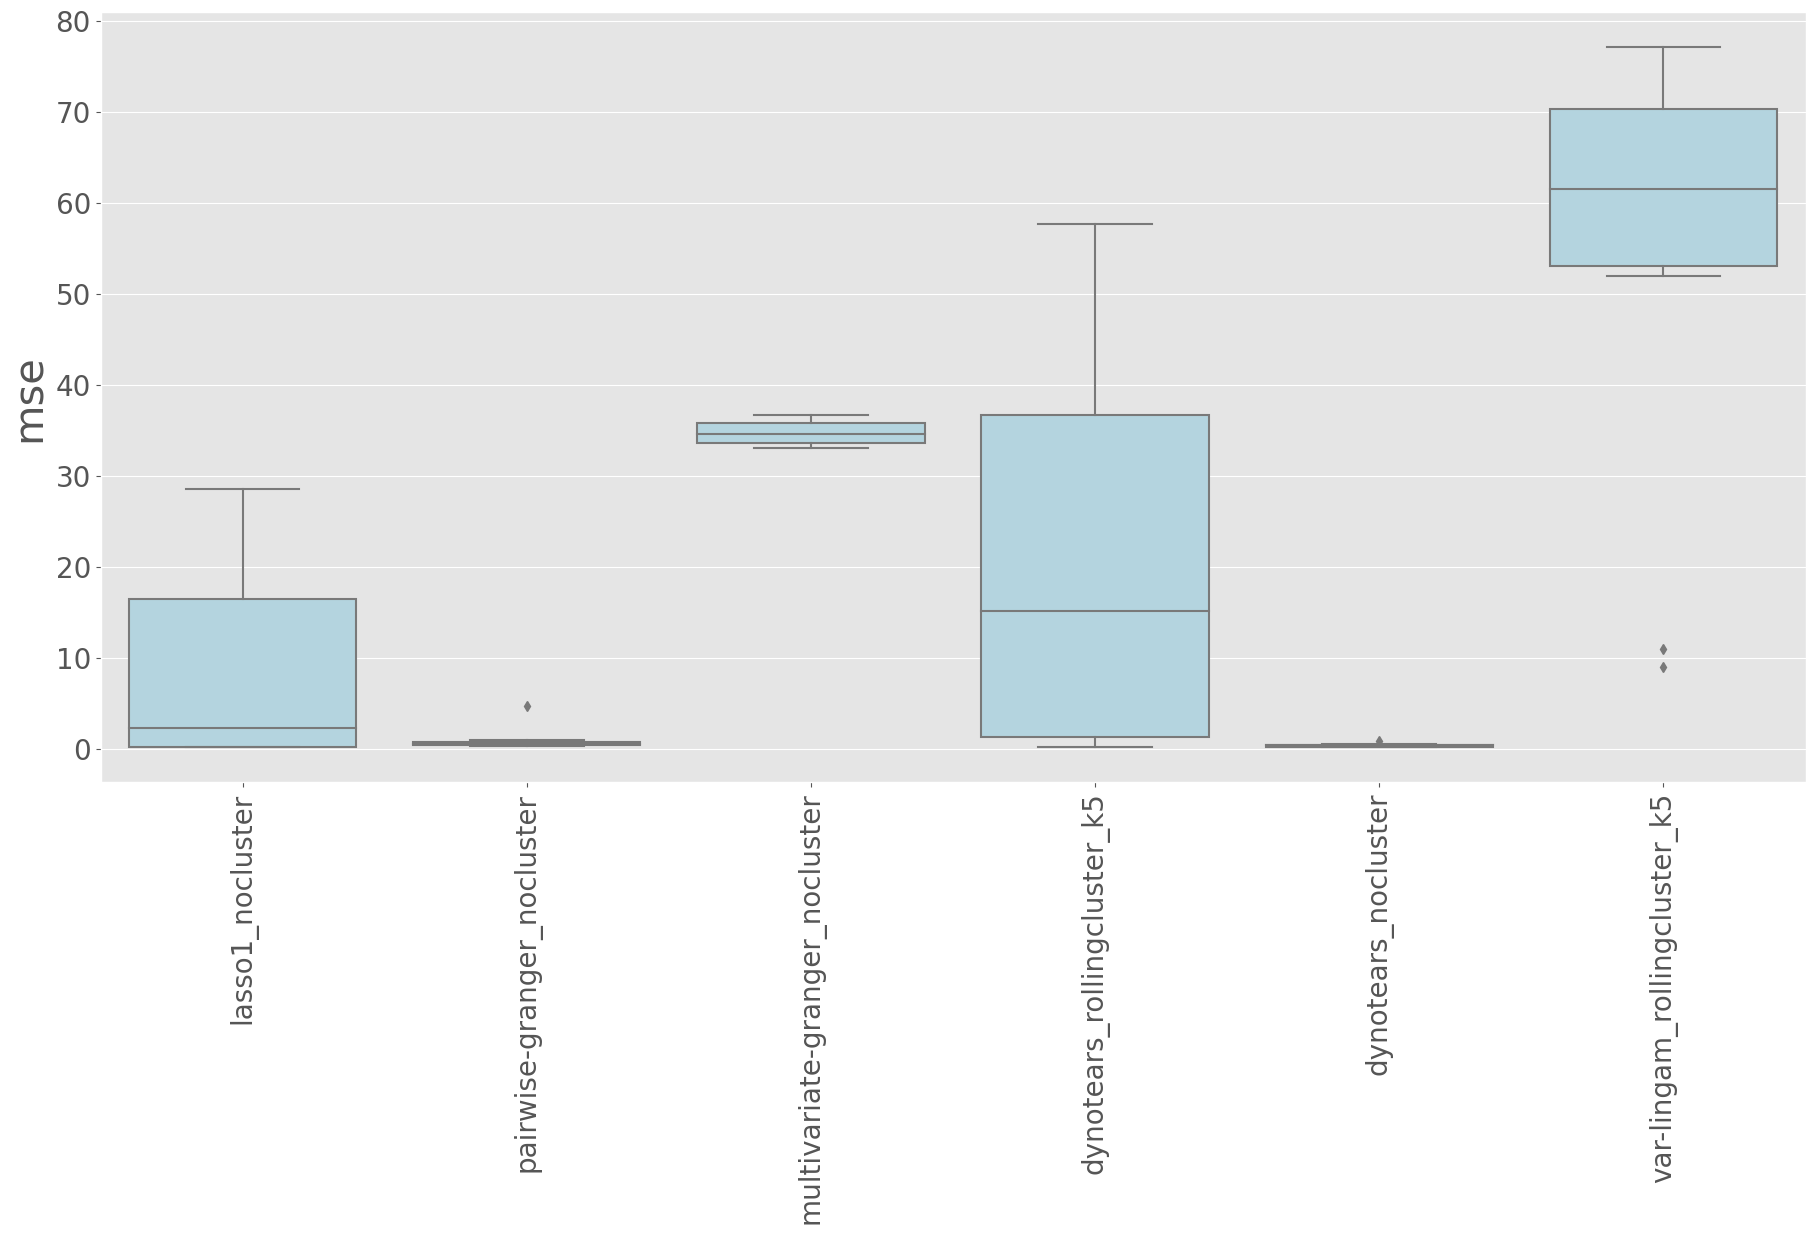

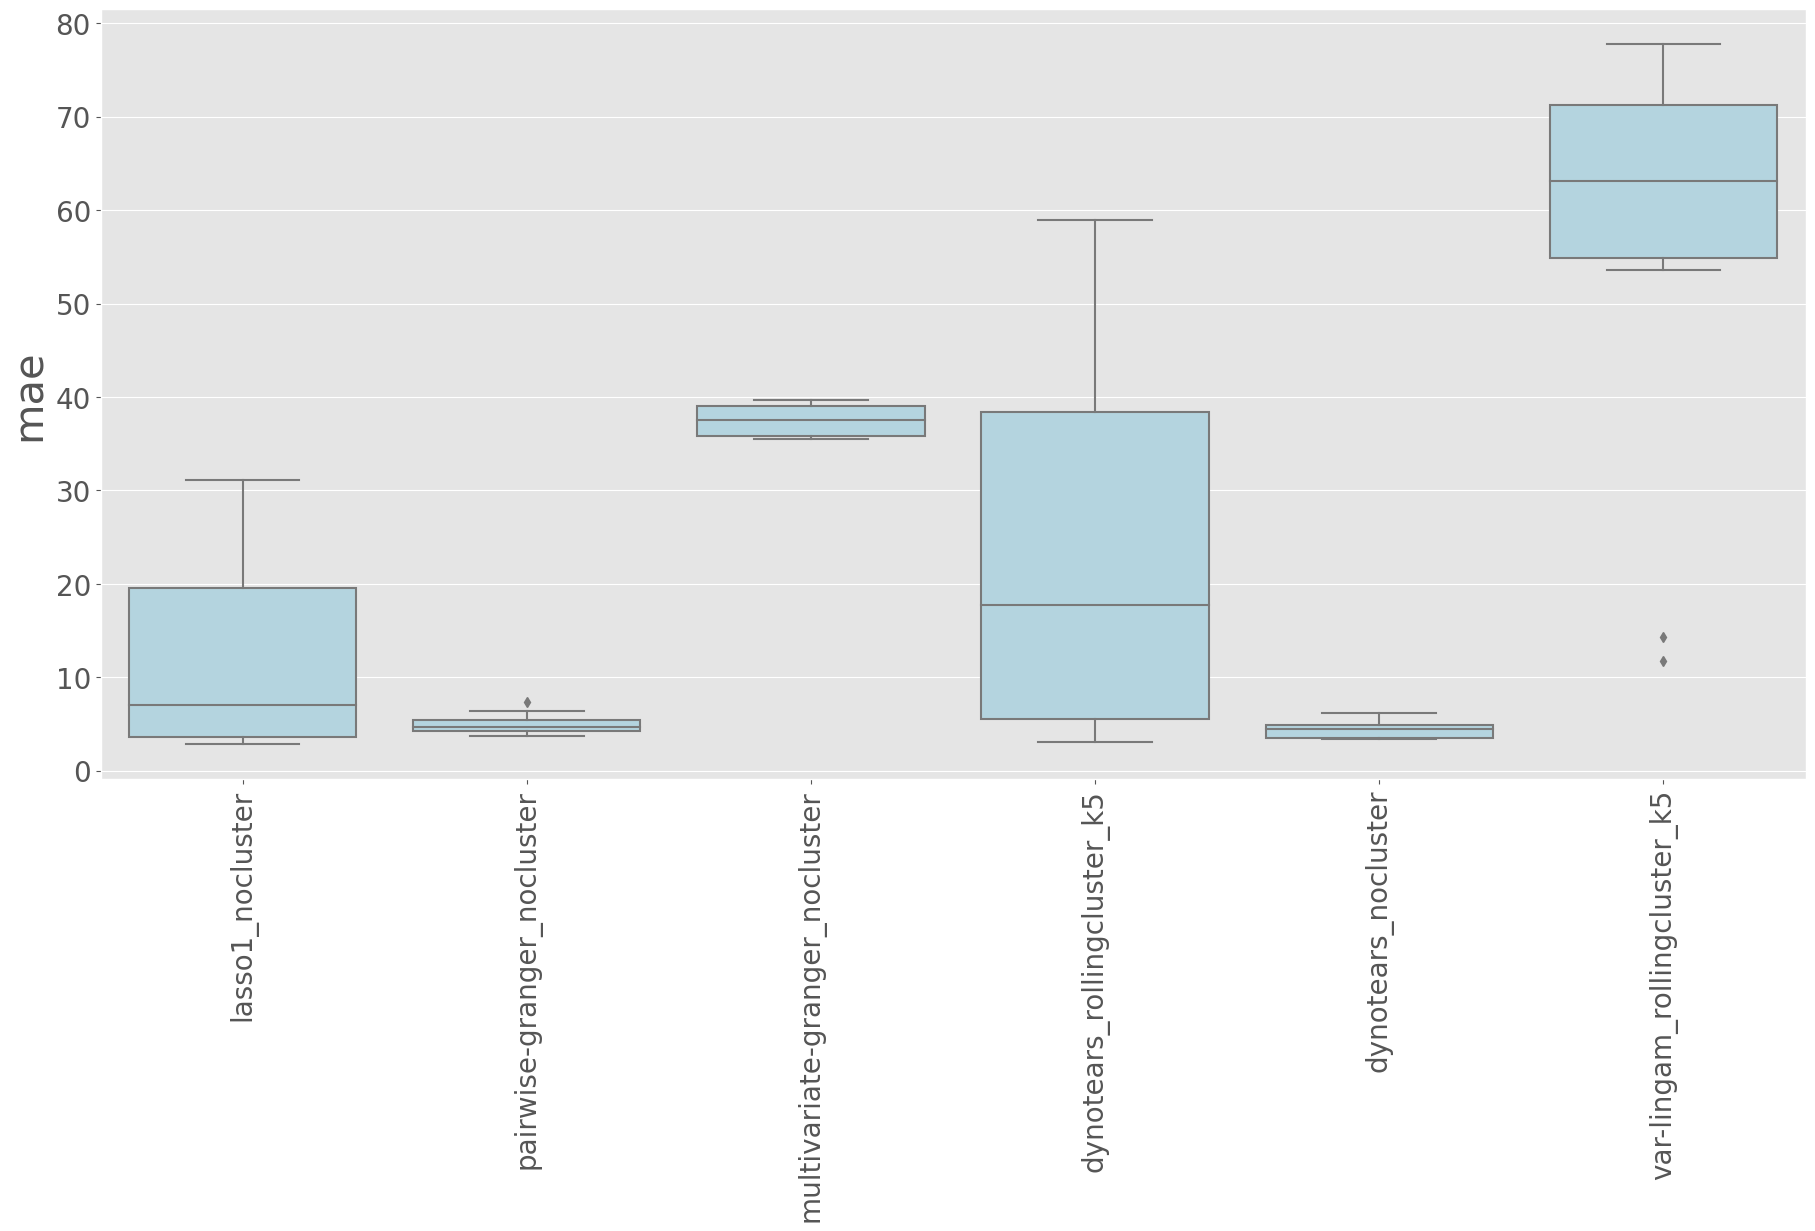

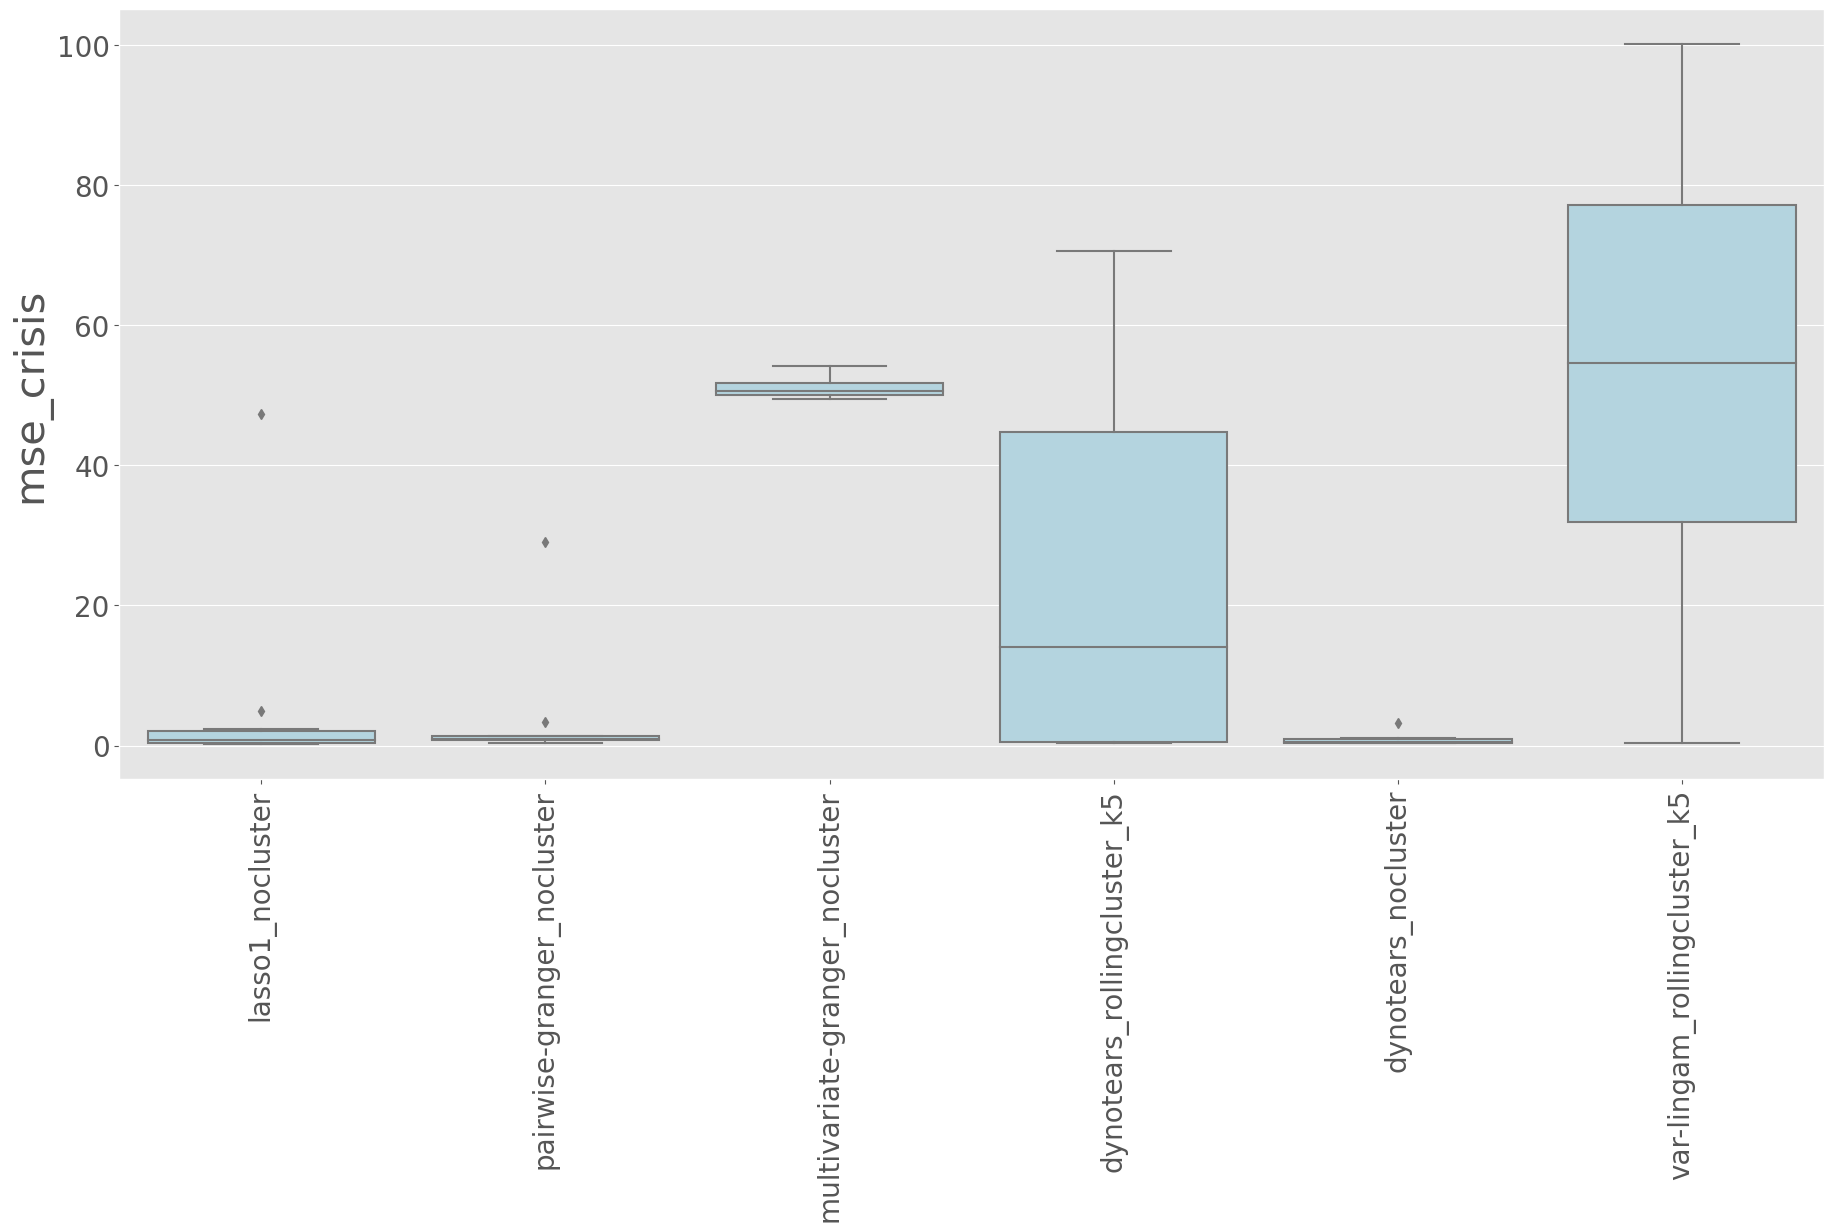

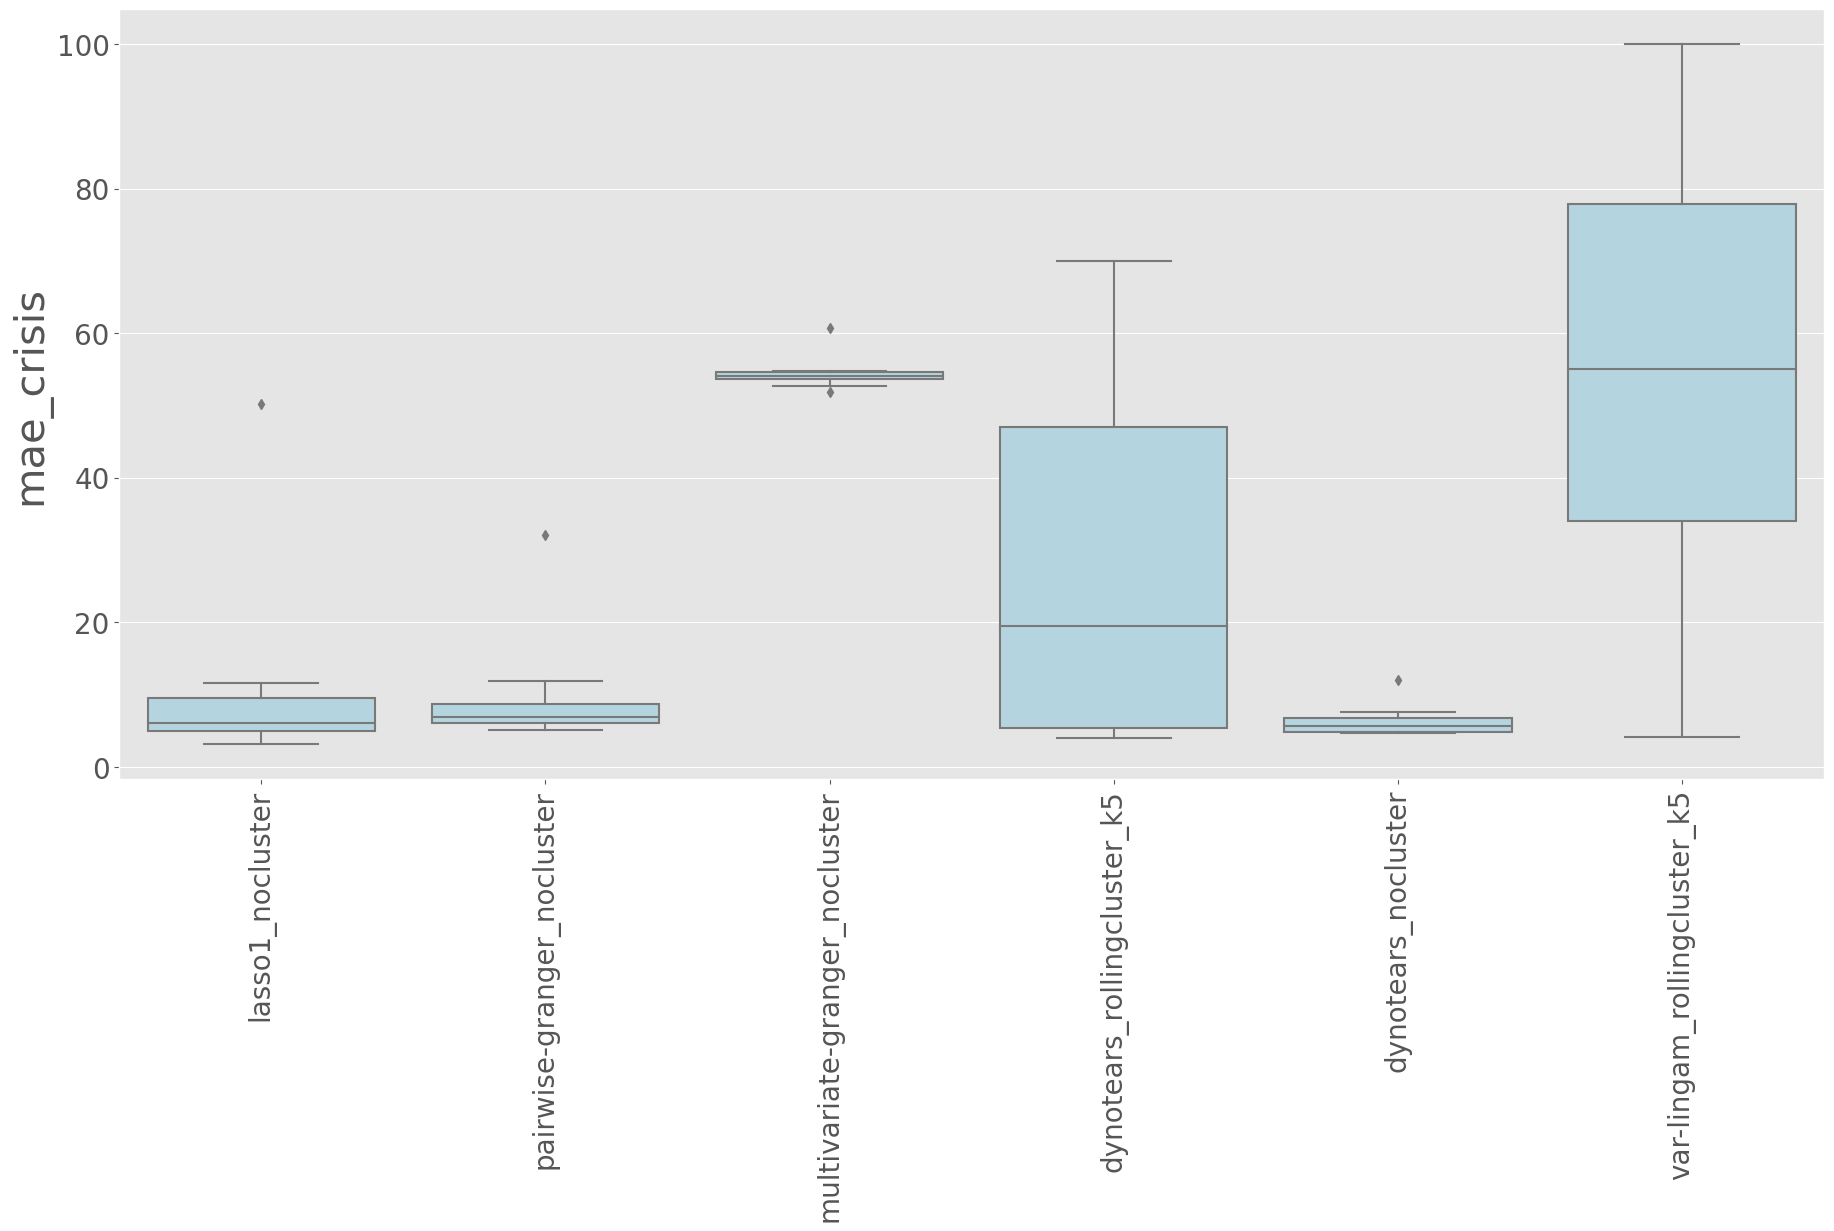

In [4]:
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_fs.png'))

## Prediction error over time

### (a) Bias-Variance Trade-off

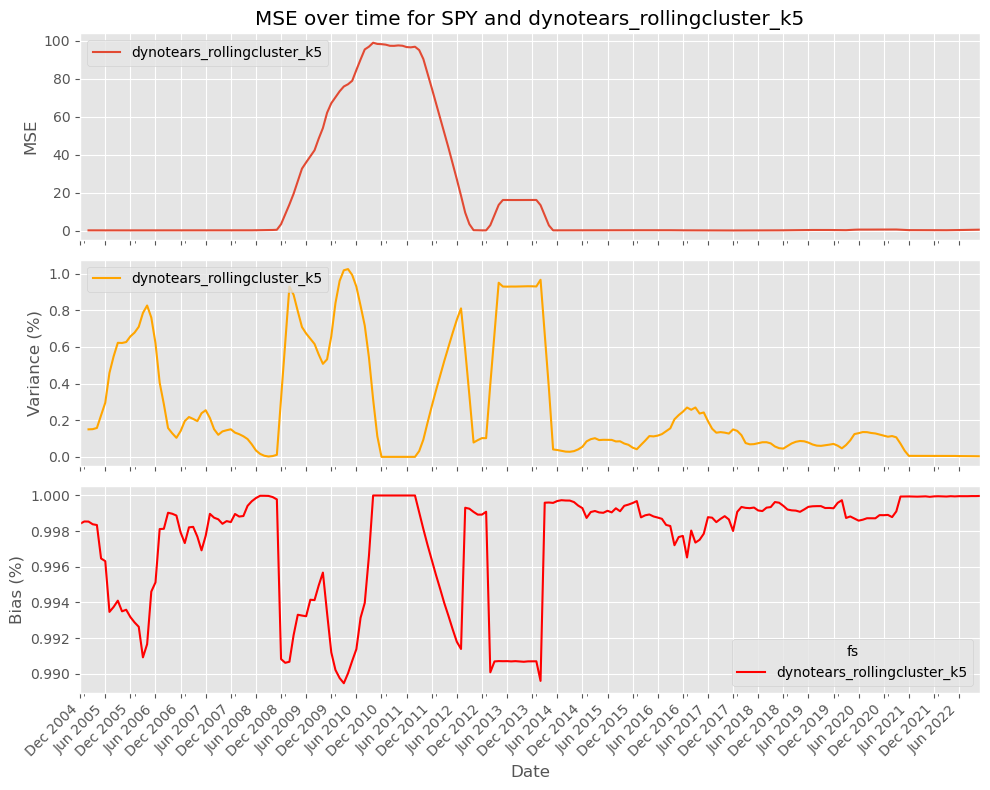

In [5]:
etf = "SPY"
fs = "dynotears_rollingcluster_k5"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

### (b) Rolling MSE

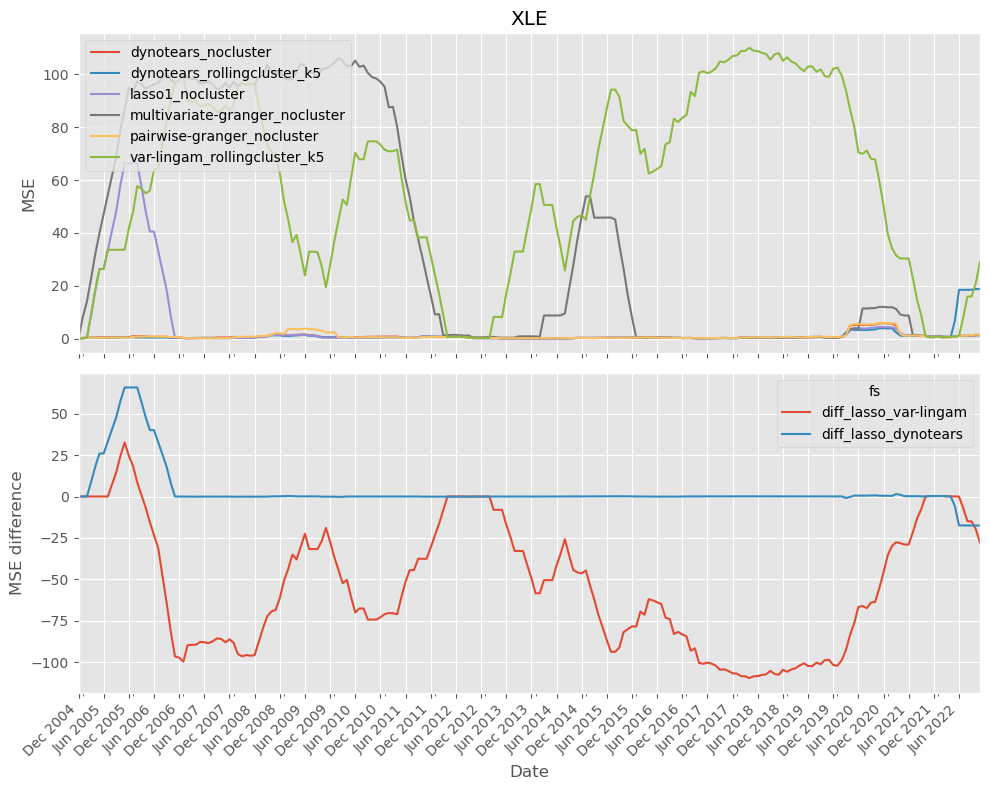

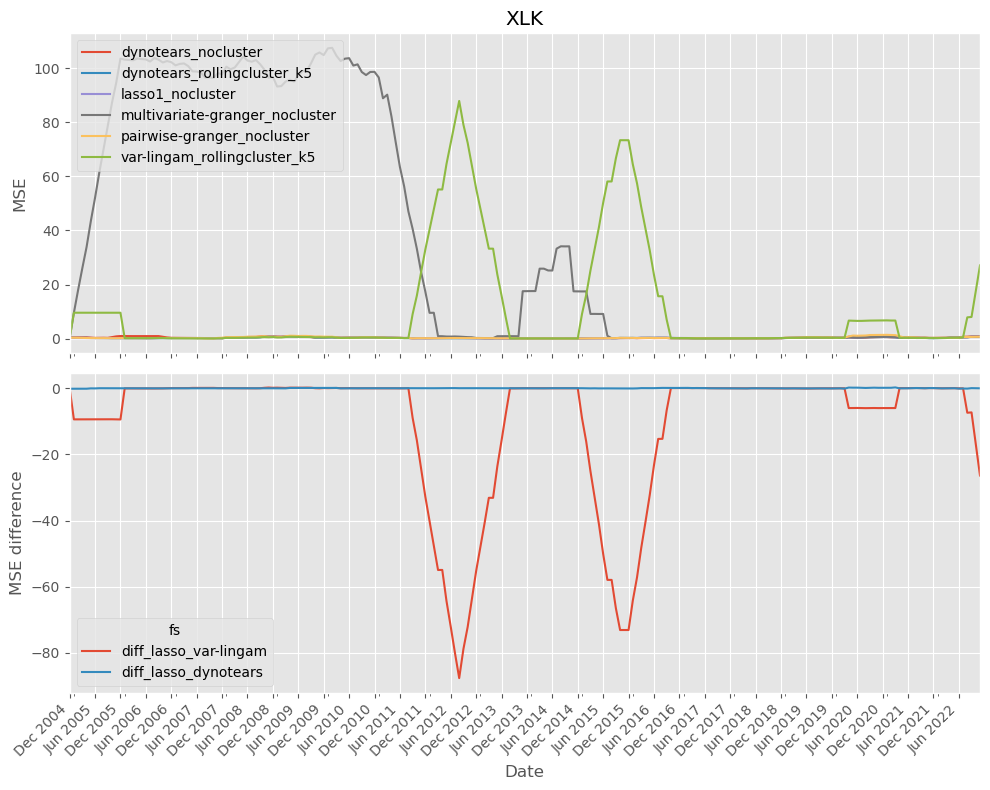

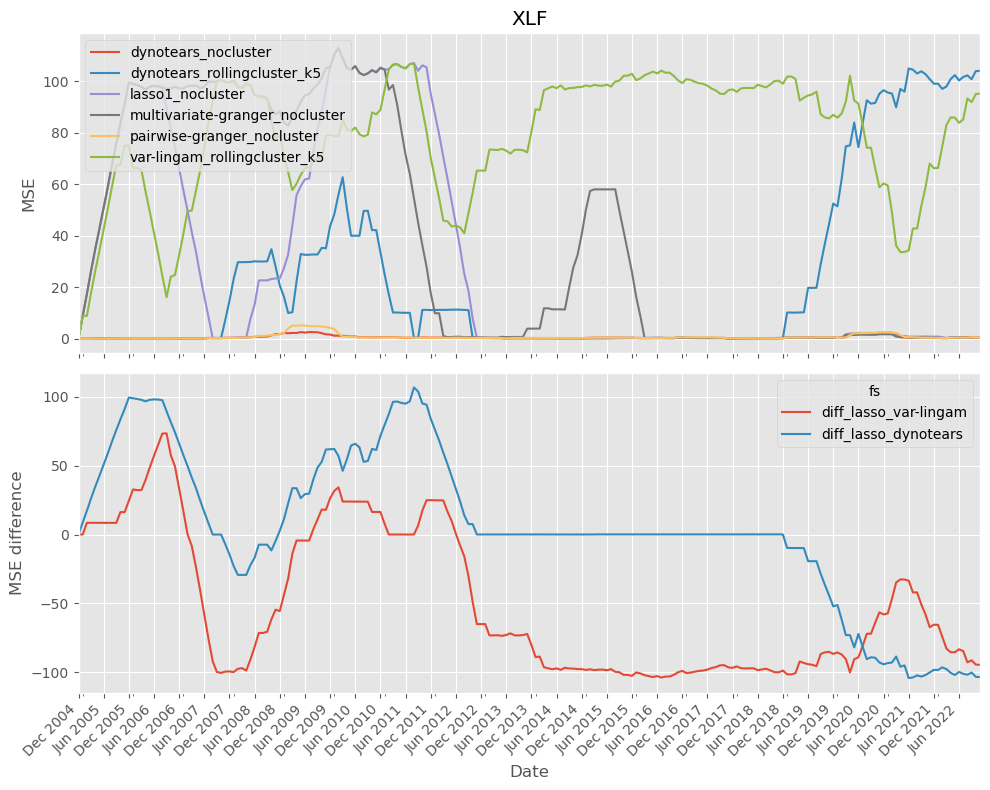

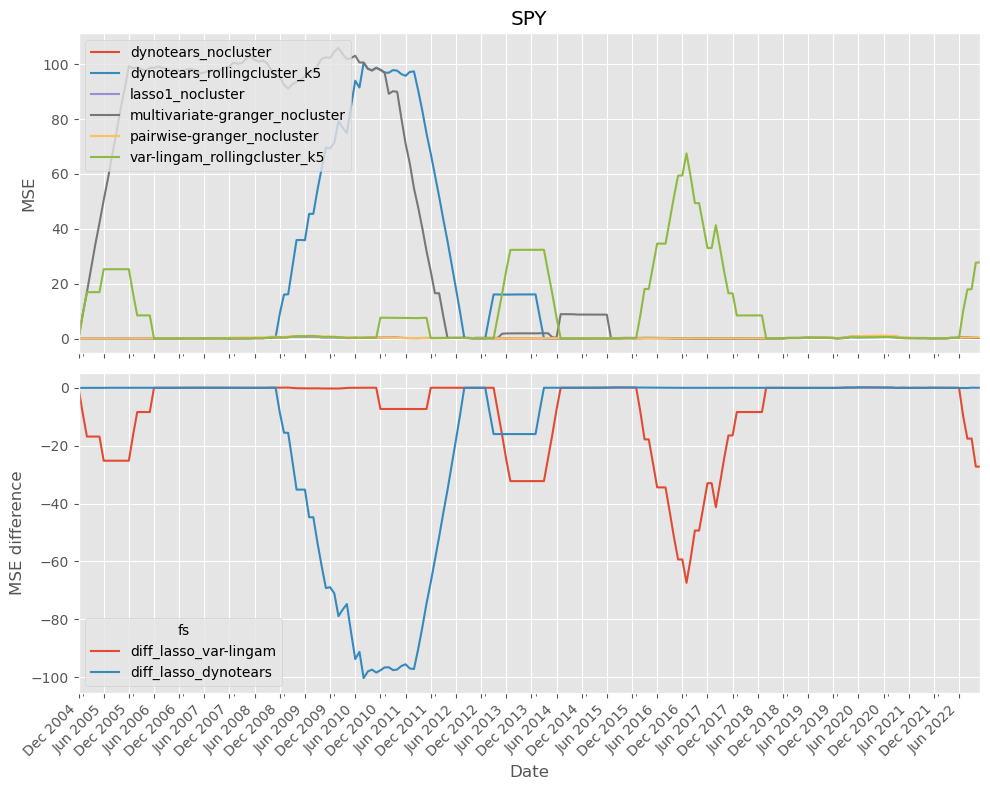

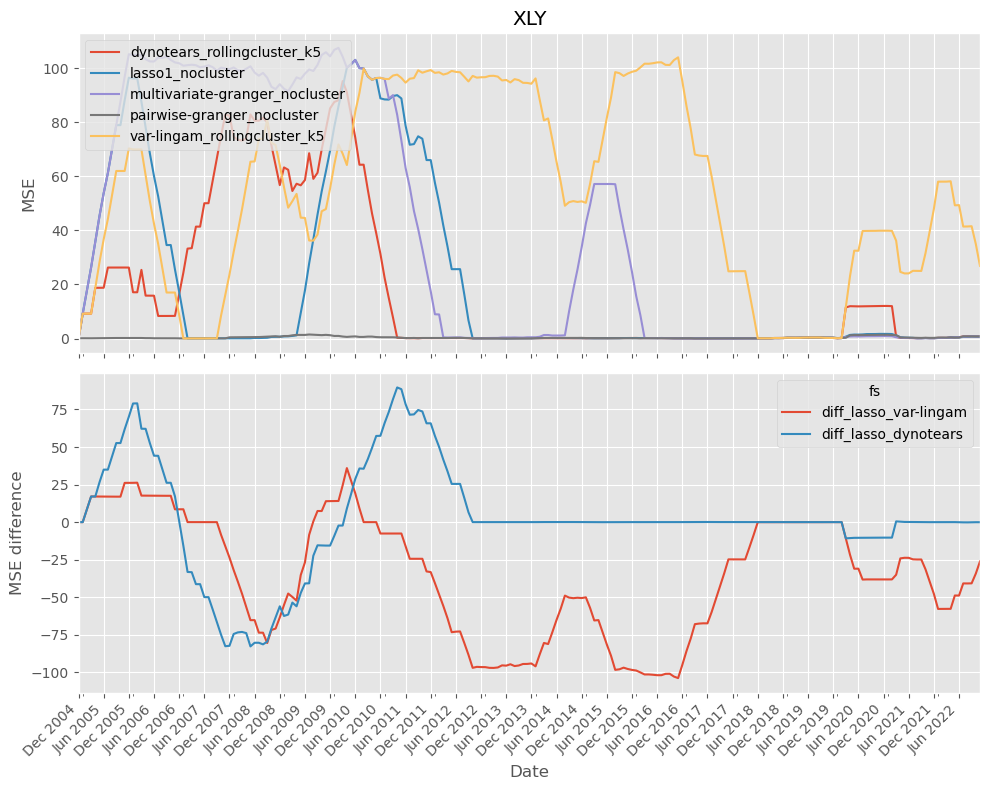

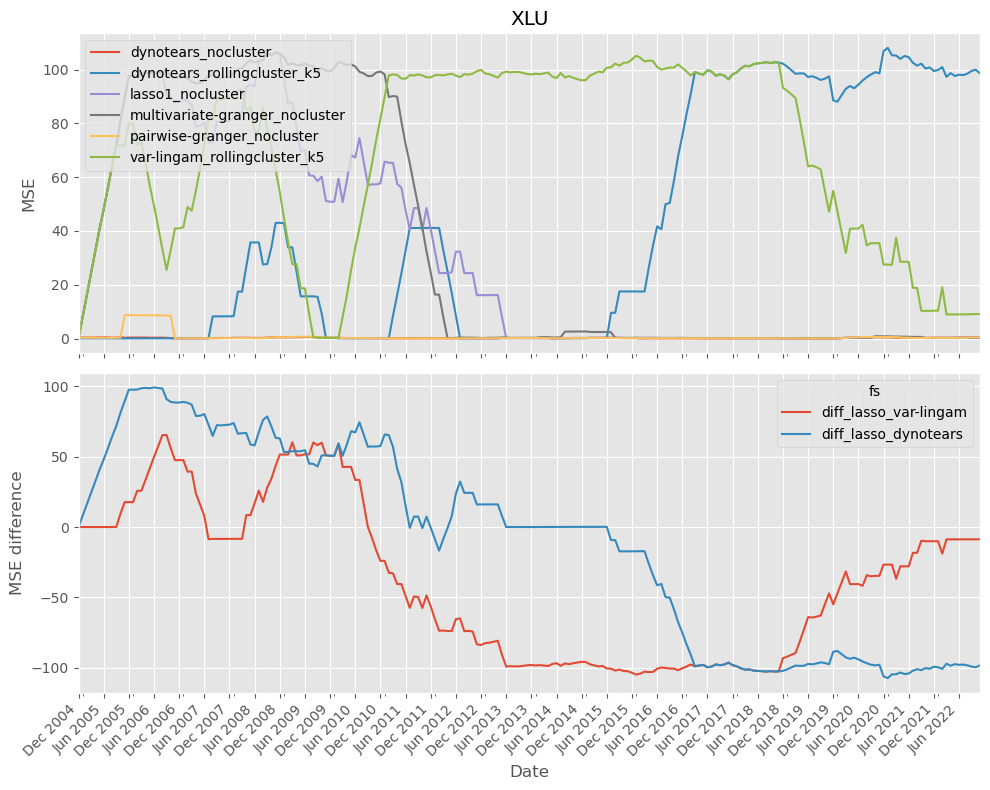

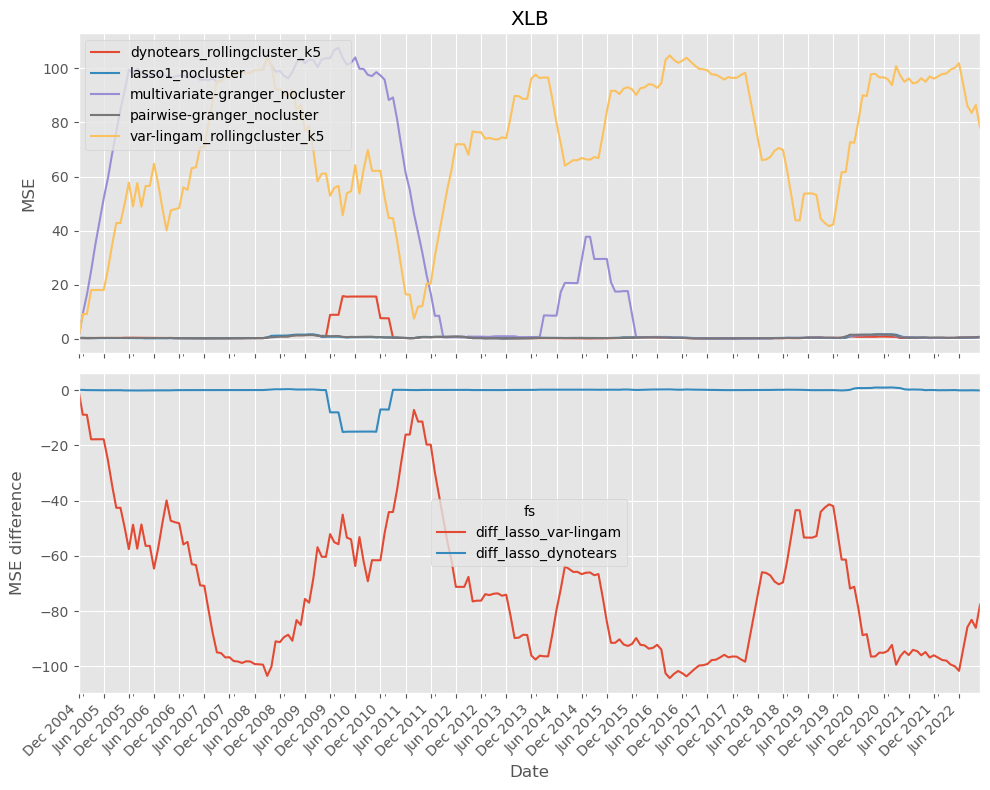

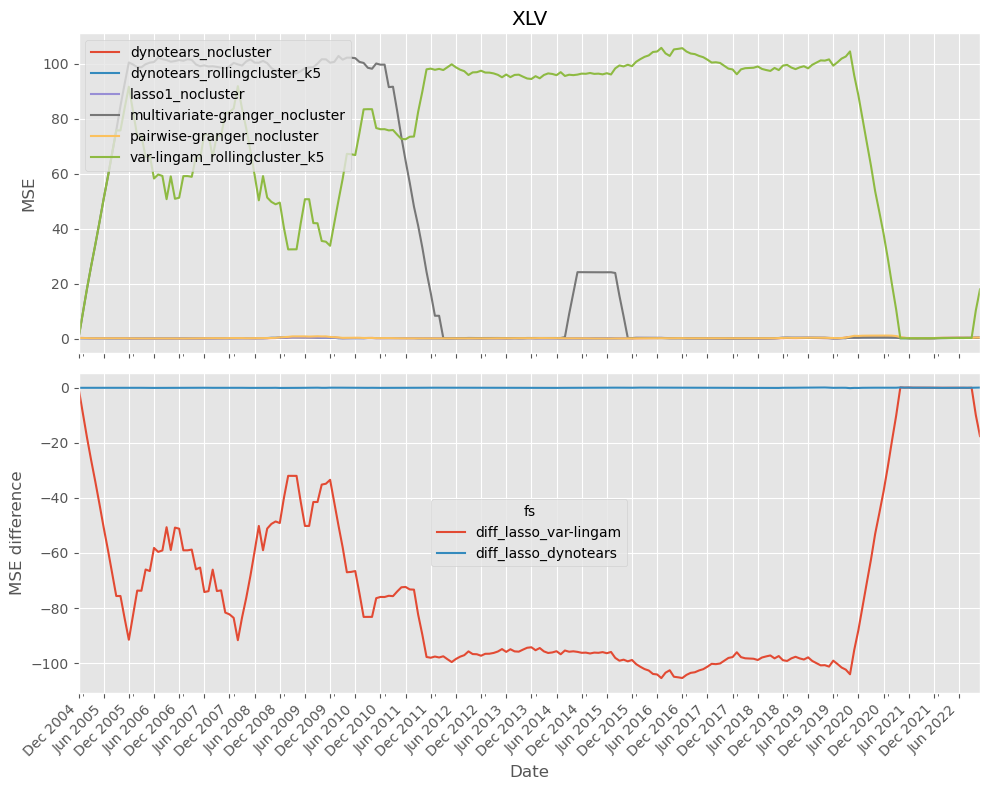

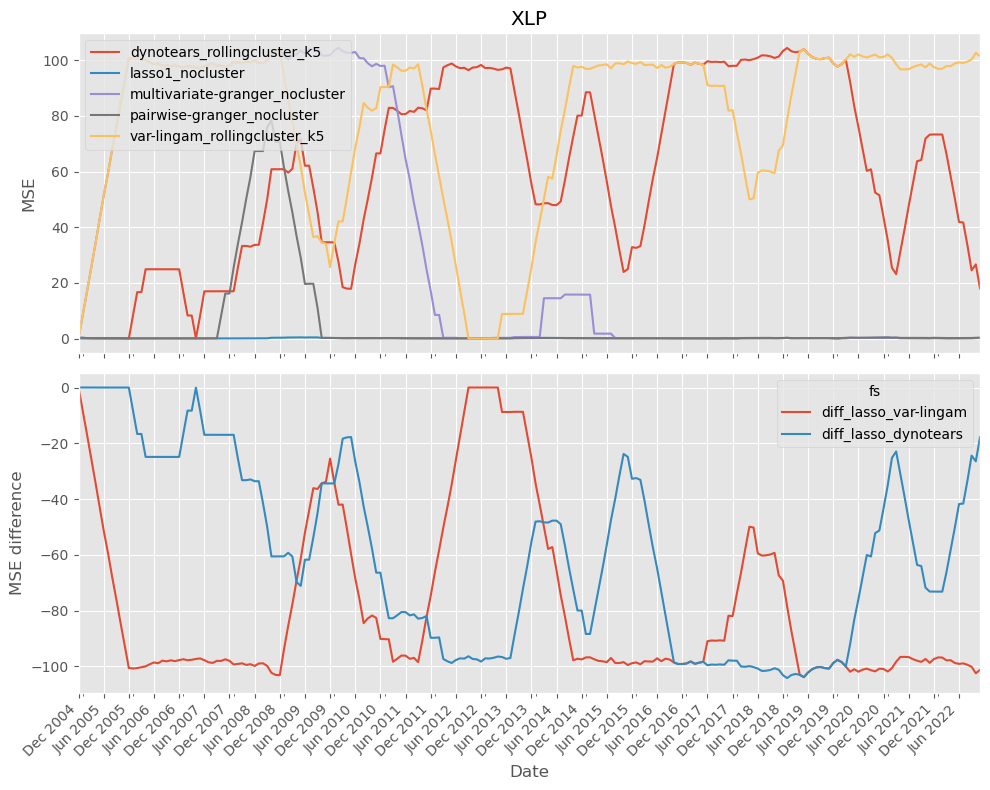

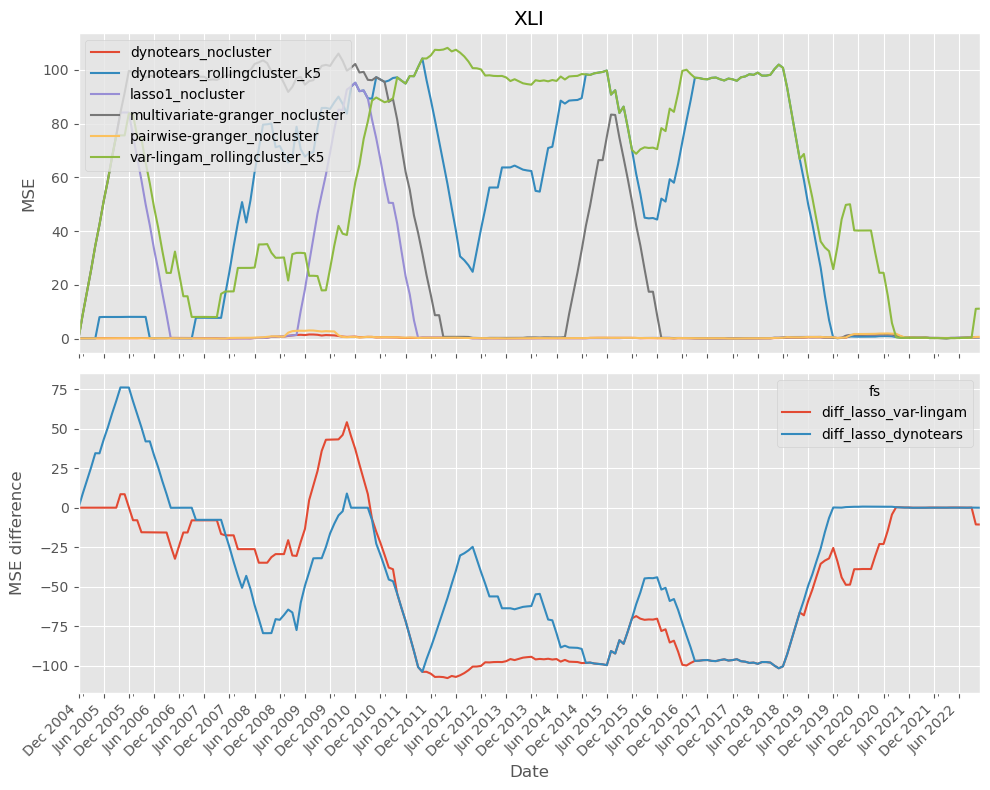

In [6]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso1_nocluster"] - etf_rolling_metrics_df["var-lingam_rollingcluster_k5"]
    etf_rolling_metrics_df["diff_lasso_dynotears"] = etf_rolling_metrics_df["lasso1_nocluster"] - etf_rolling_metrics_df["dynotears_rollingcluster_k5"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam", "diff_lasso_dynotears"], axis=1).plot(ax=axs[0])
    # etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_lasso_var-lingam", "diff_lasso_dynotears"]].plot(ax=axs[1])
    # etf_rolling_metrics_df[["diff_lasso_var-lingam"]].plot(ax=axs[1])
    # axs[1].set_title(f'MSE difference between lasso and a causal model for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mse.png'))

    # Show the plot
    plt.show()

## Selected parents over time

In [7]:
etf = "SPY"
fss = ["var-lingam", "multivariate-granger"]

In [8]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

date


In [9]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

date


## Summary Statistics Sorted by MSE

In [10]:
all_metrics_df.sort_values(by=["mse"], ascending=True)

mse        mae  mse_crisis  \
fs                             etf                                     
lasso1_nocluster               XLP   0.134633   2.830974    0.160124   
dynotears_rollingcluster_k5    XLV   0.168300   3.090107    0.306541   
lasso1_nocluster               XLV   0.179847   3.227739    0.310550   
dynotears_nocluster            XLV   0.194052   3.382069    0.418629   
lasso1_nocluster               SPY   0.202239   3.351305    0.378653   
dynotears_nocluster            SPY   0.213158   3.393651    0.430794   
                               XLU   0.238710   3.686976    0.393450   
pairwise-granger_nocluster     XLV   0.242763   3.704043    0.628194   
                               SPY   0.265559   3.699144    0.717714   
dynotears_rollingcluster_k5    XLK   0.278650   4.253828    0.474210   
lasso1_nocluster               XLK   0.315494   4.428433    0.567690   
dynotears_nocluster            XLK   0.360609   4.688634    0.499549   
pairwise-granger_nocluster     XLK   0.365706   4.519058    1.000446   
dynotears_nocluster            XLI   0.378802   4.435140    0.795988   
pairwise-granger_nocluster     XLY   0.391272   4.372524    0.965261   
lasso1_nocluster               XLB   0.422245   4.899378    0.893853   
pairwise-granger_nocluster     XLB   0.439382   4.913992    0.853227   
dynotears_nocluster            XLF   0.499611   5.144334    1.111882   
pairwise-granger_nocluster     XLI   0.506684   4.963217    1.094186   
                               XLF   0.674872   5.538294    1.423759   
                               XLU   0.676811   4.174946    0.412893   
dynotears_nocluster            XLE   0.816953   6.193020    3.203104   
pairwise-granger_nocluster     XLE   0.956422   6.405162    3.330103   
dynotears_rollingcluster_k5    XLB   1.138783   5.202855    0.467075   
                               XLE   1.572635   6.496207    2.203611   
lasso1_nocluster               XLE   4.166772   9.287777    2.385336   
pairwise-granger_nocluster     XLP   4.717956   7.368040   29.097536   
var-lingam_rollingcluster_k5   SPY   8.992908  11.741119    0.337544   
                               XLK  10.944244  14.281902    3.494014   
lasso1_nocluster               XLI  11.853383  15.269574    0.800893   
dynotears_rollingcluster_k5    SPY  13.790408  16.300422    0.348090   
                               XLY  16.406258  19.220114   46.977579   
lasso1_nocluster               XLY  18.015892  20.962407    0.926544   
dynotears_rollingcluster_k5    XLF  24.595825  27.018608   62.601159   
lasso1_nocluster               XLF  26.294904  29.229832    4.932584   
                               XLU  28.476689  31.160303   47.285972   
multivariate-granger_nocluster XLU  33.009486  35.714791   51.772772   
                               SPY  33.194110  35.777490   51.460230   
                               XLP  33.455540  35.456271   49.772318   
                               XLV  33.769650  36.110891   50.499364   
                               XLB  34.446363  37.747381   49.944497   
                               XLK  34.666452  37.325504   51.992480   
                               XLE  35.652679  39.638218   54.173156   
                               XLY  35.768712  38.403630   50.263183   
                               XLF  36.166440  39.187310   49.526374   
                               XLI  36.669966  39.658078   50.761195   
dynotears_rollingcluster_k5    XLU  40.692303  42.239559   70.639636   
                               XLI  47.968531  49.941300   26.024695   
var-lingam_rollingcluster_k5   XLY  51.886806  53.563476   52.221619   
                               XLE  56.429217  59.025310   73.139781   
dynotears_rollingcluster_k5    XLP  57.682722  58.977989   38.039943   
var-lingam_rollingcluster_k5   XLI  57.775280  59.540379   25.177242   
                               XLU  65.112854  66.646614   56.418397   
                               XLV  69.982911  71.133735   52.873753   
          

In [11]:
all_metrics_df.sort_values(by=["mse_crisis"], ascending=True)

,,mse,mae,mse_crisis,mae_crisis,stability
fs,etf,,,,,
lasso1_nocluster,XLP,0.134633,2.830974,0.160124,3.127148,5.544053
dynotears_rollingcluster_k5,XLV,0.168300,3.090107,0.306541,4.055349,0.438767
lasso1_nocluster,XLV,0.179847,3.227739,0.310550,4.277727,3.187225
var-lingam_rollingcluster_k5,SPY,8.992908,11.741119,0.337544,4.108903,0.220408
dynotears_rollingcluster_k5,SPY,13.790408,16.300422,0.348090,4.461643,0.408163
lasso1_nocluster,SPY,0.202239,3.351305,0.378653,4.640189,4.158590
dynotears_nocluster,XLU,0.238710,3.686976,0.393450,4.774089,6.907489
pairwise-granger_nocluster,XLU,0.676811,4.174946,0.412893,5.170481,7.482301
dynotears_nocluster,XLV,0.194052,3.382069,0.418629,4.935706,4.352423
